# Heat Transfer project

The aim of the project is to dimensioning an adiabatic exchanger in a typical commercial tertiary building. To do that the building load needs to be first determine.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Determination of the external parameters

The external temperature and relative humidity will be obtained from meteo datas over a week.

In [92]:
df = pd.read_excel(r"C:\Users\Jolan\Desktop\Heat transfert\Projet\Meteo.xlsx")
#df.head()
#744 lines
#The dates are not well implemented with pandas. In practice there is a measure every hour for 31 days.

In [3]:
#Data storage per day

Datas, data = [], []
#data is a list of couple T,HR along one day
#Datas is the lists of data
for i,T in enumerate(df['T dry bulb (°C)']):
    if i%24 != 0 or i==0: 
        data.append([df['T dry bulb (°C)'][i],df['HR (%)'][i]])
    else:
        Datas.append(data)
        data = []
        data.append([df['T dry bulb (°C)'][i],df['HR (%)'][i]])

The external set temperature will be first taken by doing the **mean of the temperature pic**. 

The external set relative humidity will be taken by doing the **mean of the relative humidity**.

In [89]:
#Plot the different temperatures in a day over a month
#Each plot corresponds to a day

#Creation of the lists
Time,Temp, HR = range(0,24), [],[]
for day in range(30):
    Temp.append([Datas[day][i][0] for i in Time])
    HR.append([Datas[day][i][1] for i in Time])
#plt.plot(np.transpose(Temp));
#Mean
MeanT = np.ones(24)*np.mean([np.max(Temp[i]) for i in range(30)])
MeanHR = np.ones(24)*np.mean([np.min(HR[i]) for i in range(30)])

#Quantile
# pquantile = np.zeros(24)
# Temp = np.array(Temp)
# for period in range(0,24):
#     pquantile[period] = np.quantile(Temp[:,period],0.9)
# plt.plot(Time,pquantile,'--',color = 'blue', label = f"quantile for p = {0.9}")
# MeanT = np.ones(24)*np.max(pquantile)

#Plot
# plt.plot(Time,MeanT,'--',color = 'black', label = f"Mean of the temperature pic")
# plt.ylabel("Temperature[°C]")
# plt.legend()
# plt.show()
# plt.plot(np.transpose(HR));
# plt.plot(Time,MeanHR,'--',color = 'black', label = f"Mean of the HR")
# plt.xlabel("Time [hour]")
# plt.ylabel("HR [%]");
# plt.legend();
#plt.savefig("HR.png",dpi=200)

#Print
T_ext, HR_ext = MeanT[0], MeanHR[0]
print(f'The external temperature selected is {T_ext} °C')
print(f'The external relative humidity selected is {HR_ext} %')

The external temperature selected is 32.54383000972807 °C
The external relative humidity selected is 31.08366961406167 %


## Calculation of the builing load

$$ Q_{load}= [S_l(\%_{fen}*U_{fen}+(1-\%_{fen})U_{wall})+S(U_{floor}+U_{roof})](T_{ext}-T_{set})+S*(Q_{pers}*N_{pers}+Light)$$

In [5]:
#Parameters
Tset = 25

S = 400
h = 6
Uf = 1.6+0.33+0.6
Ur = 0.25
Sl = 480
Uw = 1.5
Ufen = 1.8
Perfen = 0.4
#Personne and radiation
Np = 1/4 #per/m^2
Qp = 80 #W/per au repos
Light = 5 #W/m^2

In [6]:
def Q_load(Tset, Text):
    return (Text-Tset)*(Sl*(Perfen*Ufen + (1-Perfen)*Uw)+S*(Uf+Ur))+S*(Light+Np*Qp)

In [7]:
Qload = Q_load(Tset,T_ext)

print(f"Q_load is {Qload*1e-3} kW")

Q_load is 24.254821186382156 kW


## Dimensionner

In [8]:
from CoolProp.HumidAirProp import HAPropsSI
import psychrolib as pl

In [9]:
#Parameters
Cp_air = 1005 #J/K/kg
Gp = 0.25 #kg/h/pers

#Hypothesis
m_air = 130* 0.00047194745*Np*S*1.2;print(f'Flux of air is {m_air} kg/s')

#Verifier le temps de renouveler la salle /h
m_air/1.2*3600/(S*h) #<30

Flux of air is 7.3623802199999995 kg/s


9.202975274999998

In [83]:
#Deduce T_ air soufflé en K
T_souf = Tset+273.15 - Qload/(m_air*Cp_air) ; print(f"T_souf = {T_souf-273.15}°C")

#Calcultation h_ext en J/kg
h_ext = HAPropsSI('H', 'T', T_ext+273.15,'P', 101325, 'R', HR_ext/100);print(f"h_ext = {h_ext} J/kg")

#Deduce HR% air soufflé
HR_souf = HAPropsSI('R', 'T', T_souf, 'P', 101325, 'H', h_ext);print(f"HR_souf = {HR_souf*100}%")

#Calculation of the efficiency
Tdb = HAPropsSI('Twb', 'T', T_ext+273.15, 'P', 101325, "R", HR_ext/100)
eff = (T_souf-273.15-T_ext)/(Tdb-273.15-T_ext); print(f"The efficiency is {eff*100}%")

#Calculation of the debit of water
w_ext = HAPropsSI('W', 'T', T_ext+273.15, 'P', 101325, 'R',HR_ext/100); #kg d'eau/ kg d'air
w_souff = HAPropsSI('W','T',T_souf,'P',101325,'R',HR_souf); #kg d'eau/ kg d'air
m_water = m_air*(w_souff-w_ext); print(f"Flux of water is {m_water} kg/s")

#Deduce HR_set
w_room = w_souff - (Gp/3600*Np*S)/m_air;
HR_room = HAPropsSI('R', 'T', Tset+273.15, 'P', 101325, 'W', w_room);print(f"HR_room = {HR_room*100}%")
#Check if between 40 and 65%

#If T_ext_pic and HR_min what is the temperature and HR inside the building:
print("")
print('If the outside temperature is at the highest peak and the relative humidity the lower:')
T_extmax = np.max([np.max(Temp[i]) for i in range(30)]) #°C
HR_extmin = np.min([np.min(HR[i]) for i in range(30)]) #%
Qloadmax = Q_load(Tset, T_extmax)
#new T_souff
Tdbmax = HAPropsSI('Twb', 'T', T_extmax+273.15, 'P', 101325, "R", HR_extmin/100)
T_soufmax = T_extmax + eff*(Tdbmax - 273.15-T_extmax);
#new T_set
T_room = T_soufmax+273.15 + Qloadmax/(m_air*Cp_air); print(f'T_roommax = {T_room-273.15} °C')
#new enthalpy
h_extmax = HAPropsSI('H', 'T', T_extmax+273.15,'P', 101325, 'R', HR_extmin/100);
HR_soufmax = HAPropsSI('R', 'T', T_soufmax+273.15, 'P', 101325, 'H', h_extmax);
#new indoor HR
w_souffmax = HAPropsSI('W','T',T_soufmax+273.15,'P',101325,'R',HR_soufmax);
w_roommax = w_souffmax - (Gp/3600*Np*S)/m_air;
HR_roommax = HAPropsSI('R', 'T', T_room, 'P', 101325, 'W', w_roommax);print(f"HR_roommin = {HR_roommax*100}%")

T_souf = 21.72196358880649°C
h_ext = 57195.4744005419 J/kg
HR_souf = 84.90909252282361%
The efficiency is 86.42650365386397%
Flux of water is 0.03214170120054406 kg/s
HR_room = 65.034871469055%

If the outside temperature is at the highest peak and the relative humidity the lower:
T_roommax = 26.357181207176836 °C
HR_roommin = 56.16560452698198%


## Technico-economic

Wp = 93.21093348157778 W
Wf = 5521.785164999999 W
COP = 4.319650585855476
12.751069704071876 semaines


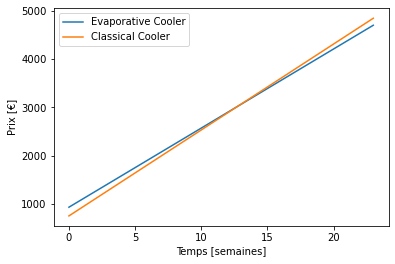

In [82]:
# Work of the pump
deltaP = (30-1)*1e5
Wp = m_water*deltaP/1000; print(f'Wp = {Wp} W')

#Work of the fan
Cons = 0.25*3600 #J/m3
Wf = m_air/1.2*Cons ; print(f'Wf = {Wf} W')

#COP
COP = Qload/(Wp+Wf); print(f'COP = {COP}')

#Price
Prixelec = 0.1740 #€/kWh
Pricepump = 96.78 #€
Pricefan = 834 #€
CAPEX = Pricepump + Pricefan
OPEX = (Wp+Wf)*1e-3*Prixelec*24*7 #€/h

CAPEXClass = 750
OPEXClass = 6.1*Prixelec*24*7

#Plot
Time = range(0,4*6) #jours
Prix = [CAPEX + OPEX*t for t in Time] #€
PrixClass = [CAPEXClass + OPEXClass*t for t in Time] #€
plt.plot(Time,Prix,label = 'Evaporative Cooler')
plt.plot(Time,PrixClass, label = 'Classical Cooler')
plt.xlabel('Temps [semaines]')
plt.ylabel('Prix [€]')
plt.legend()
Tequal = (CAPEX-CAPEXClass)/(OPEXClass-OPEX);print(f'{Tequal} semaines')

## Sensibility study and check of an optimum

In [63]:
#Plot function
def Plot(X,Y,color,xlabel = None,ylabel = None,title=None,label=None):
    plt.plot(X,Y,color = color, label = label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis='y')
    if label!=None:
        plt.legend()

### Verify the stability at a constant air flow

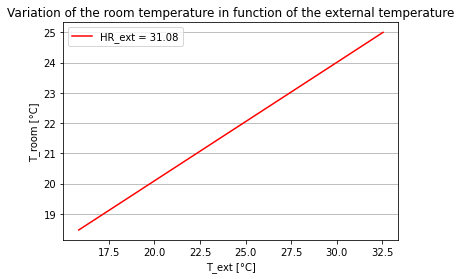

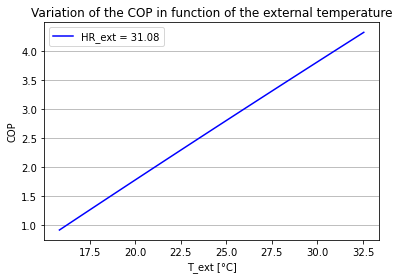

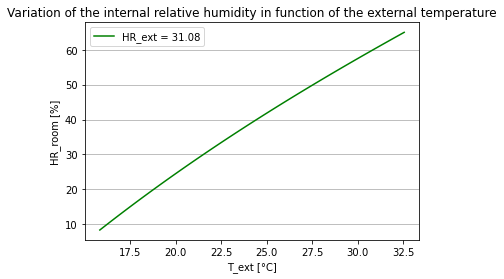

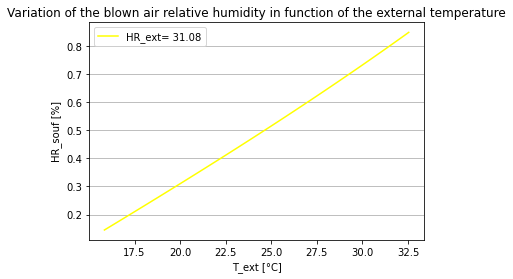

In [13]:
#Variation of the external temperature over the room temperature and the COP

T_EXT = np.linspace(np.min(Temp),T_ext,100) #°C
#new T_souff
TDB = [HAPropsSI('Twb', 'T', T_ext+273.15, 'P', 101325, "R", HR_ext/100) for T_ext in T_EXT]
T_SOUF = [T_ext + eff*(Tdb - 273.15-T_ext) for (T_ext,T_db) in zip(T_EXT,TDB)];
#new T_set
#Hypothesis: Considere our T_set for the Q_load
QLOAD = [Q_load(Tset, Text) for Text in T_EXT]
T_ROOM = [T_souf+273.15 + Qload/(m_air*Cp_air) for (T_souf,Qload) in zip(T_SOUF,QLOAD)]
#new enthalpy
h_EXT = [HAPropsSI('H', 'T', T_ext+273.15,'P', 101325, 'R', HR_ext/100) for T_ext in T_EXT];
HR_SOUF = [HAPropsSI('R', 'T', T_souf+273.15, 'P', 101325, 'H', h_ext) for (T_souf,h_ext) in zip(T_SOUF,h_EXT)];
#new indoor HR
w_SOUF = [HAPropsSI('W','T',T_souf+273.15,'P',101325,'R',HR_souf) for (T_souf,HR_souf) in zip(T_SOUF,HR_SOUF)];
w_ROOM = [w_souf - (Gp/3600*Np*S)/m_air for w_souf in w_SOUF];
HR_ROOM = [HAPropsSI('R', 'T', T_room, 'P', 101325, 'W', w_room) for (T_room,w_room) in zip(T_ROOM,w_ROOM)]
#Calculation of the debit of water
w_EXT = [HAPropsSI('W', 'T', T_ext+273.15, 'P', 101325, 'R',HR_ext/100) for T_ext in T_EXT]; #kg d'eau/ kg d'air
m_WATER = [m_air*(w_souf-w_ext) for (w_souf,w_ext) in zip(w_SOUF,w_EXT)]
#Calculation of the COP
# Work of the pump
WP = [m_water*deltaP/1000 for m_water in m_WATER]
#Work of the fan
WF = [m_air/1.2*Cons for m_water in m_WATER]
#COP
QLOAD = [Q_load(Tset-273.15, Text) for (Text,Tset) in zip(T_EXT,T_ROOM)]
COP = [Qload/(Wp+Wf) for (Wp,Qload) in zip(WP,QLOAD)]

#Plot
T_ROOM = [T_room -273.15 for T_room in T_ROOM]
Plot(T_EXT,T_ROOM,'red','T_ext [°C]','T_room [°C]',
     'Variation of the room temperature in function of the external temperature',f'HR_ext = {round(HR_ext,2)}')
plt.show()
Plot(T_EXT,COP,'blue','T_ext [°C]','COP',
     'Variation of the COP in function of the external temperature',f'HR_ext = {round(HR_ext,2)}')
plt.show()
HR_ROOM = [HR_room*100 for HR_room in HR_ROOM]
Plot(T_EXT,HR_ROOM,'green','T_ext [°C]','HR_room [%]',
     'Variation of the internal relative humidity in function of the external temperature',f'HR_ext = {round(HR_ext,2)}')
plt.show()
Plot(T_EXT,HR_SOUF,'yellow','T_ext [°C]','HR_souf [%]',
     'Variation of the blown air relative humidity in function of the external temperature',label = f'HR_ext= {round(HR_ext,2)}')

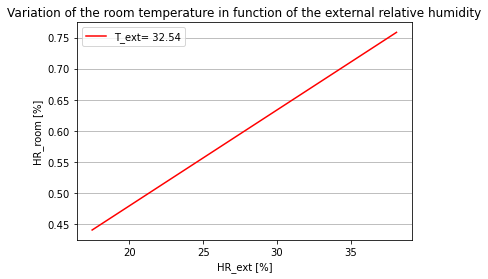

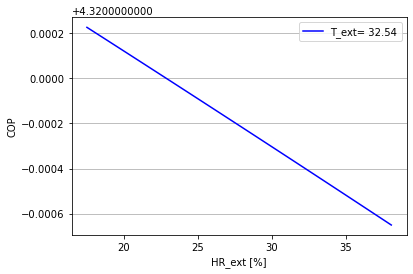

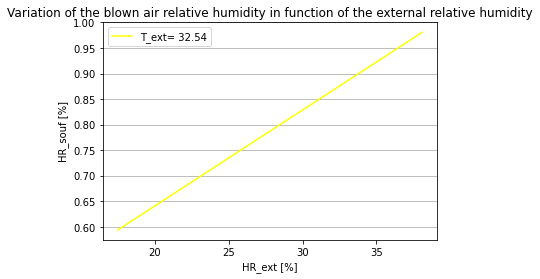

In [14]:
#Variation of the external relative humidity over the room temperature and the COP

HR_EXT = np.linspace(np.min(HR),np.max(HR)-50,100) #%
#new T_souff
TDB = [HAPropsSI('Twb', 'T', T_ext+273.15, 'P', 101325, "R", HR_ext/100) for HR_ext in HR_EXT]
T_SOUF = [T_ext + eff*(Tdb - 273.15-T_ext) for T_db in TDB];
#new T_set
#Hypothesis: Considere our T_set for the Q_load
QLOAD = [Q_load(Tset, Text) for Text in T_EXT]
T_ROOM = [T_souf+273.15 + Qload/(m_air*Cp_air) for T_souf in T_SOUF]
#new enthalpy
h_EXT = [HAPropsSI('H', 'T', T_ext+273.15,'P', 101325, 'R', HR_ext/100) for HR_ext in HR_EXT];
HR_SOUF = [HAPropsSI('R', 'T', T_souf+273.15, 'P', 101325, 'H', h_ext) for (T_souf,h_ext) in zip(T_SOUF,h_EXT)];
#new indoor HR
w_SOUF = [HAPropsSI('W','T',T_souf+273.15,'P',101325,'R',HR_souf) for (T_souf,HR_souf) in zip(T_SOUF,HR_SOUF)];
w_ROOM = [w_souf - (Gp/3600*Np*S)/m_air for w_souf in w_SOUF];
HR_ROOM = [HAPropsSI('R', 'T', T_room, 'P', 101325, 'W', w_room) for (T_room,w_room) in zip(T_ROOM,w_ROOM)]
#Calculation of the debit of water
w_EXT = [HAPropsSI('W', 'T', T_ext+273.15, 'P', 101325, 'R',HR_ext/100) for HR_ext in HR_EXT]; #kg d'eau/ kg d'air
m_WATER = [m_air*(w_souf-w_ext) for (w_souf,w_ext) in zip(w_SOUF,w_EXT)]
#Calculation of the COP
# Work of the pump
WP = [m_water*deltaP/1000 for m_water in m_WATER]
#Work of the fan
WF = [m_air/1.2*Cons for m_water in m_WATER]
#COP
QLOAD = [Q_load(Tset-273.15, Text) for (Text,Tset) in zip(T_EXT,T_ROOM)]
COP = [Qload/(Wp+Wf) for Wp in WP]

#Plot
#T_room is constant in function of relative humidity
#HR_room vs HR_ext
T_ROOM = [T_room -273.15 for T_room in T_ROOM]
Plot(HR_EXT,HR_ROOM,'red','HR_ext [%]','HR_room [%]',
     'Variation of the room temperature in function of the external relative humidity',f'T_ext= {round(T_ext,2)}')
plt.show()
Plot(HR_EXT,COP,'blue','HR_ext [%]','COP',label = f'T_ext= {round(T_ext,2)}')
plt.show()
Plot(HR_EXT,HR_SOUF,'yellow','HR_ext [%]','HR_souf [%]',
     'Variation of the blown air relative humidity in function of the external relative humidity',label = f'T_ext= {round(T_ext,2)}')

### Variation of the air flow

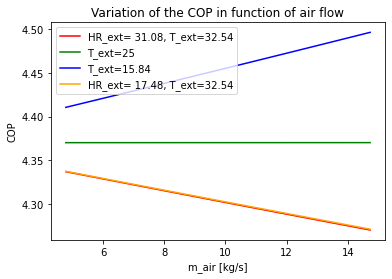

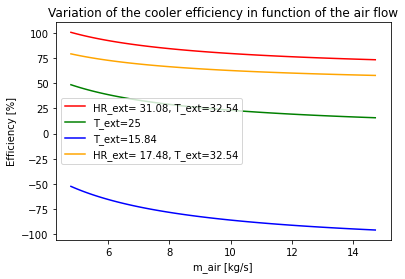

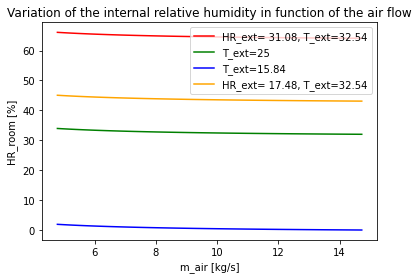

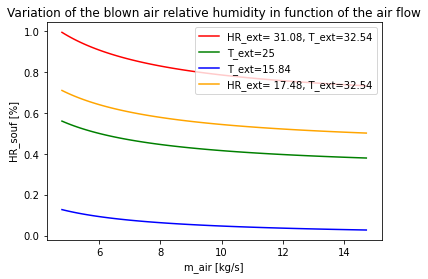

In [46]:
p = 0.65
m_AIR = np.linspace(p*m_air,2*m_air,100) #kg/s

def Variation_mair(T_ext,HR_ext,m_AIR):
    #Deduce T_ air soufflé en K
    T_SOUF = [Tset+273.15 - Qload/(m_air*Cp_air) for m_air in m_AIR]
    #Calcultation h_ext en J/kg
    h_ext = HAPropsSI('H', 'T', T_ext+273.15,'P', 101325, 'R', HR_ext/100)
    #Deduce HR% air soufflé
    HR_SOUF = [HAPropsSI('R', 'T', T_souf, 'P', 101325, 'H', h_ext) for T_souf in T_SOUF]
    #Calculation of the efficiency
    Tdb = HAPropsSI('Twb', 'T', T_ext+273.15, 'P', 101325, "R", HR_ext/100)
    EFF = [((T_souf-273.15-T_ext)/(Tdb-273.15-T_ext))*100 for T_souf in T_SOUF] # %
    #Calculation of the debit of water
    w_ext = HAPropsSI('W', 'T', T_ext+273.15, 'P', 101325, 'R',HR_ext/100); #kg d'eau/ kg d'air
    w_SOUF = [HAPropsSI('W','T',T_souf,'P',101325,'R',HR_souf) for (T_souf,HR_souf) in zip(T_SOUF,HR_SOUF)] #kg d'eau/ kg d'air
    m_WATER = [m_air*(w_souf-w_ext) for (m_air,w_souf) in zip(m_AIR,w_SOUF)] #kg/s
    #Deduce HR_set
    w_ROOM = [w_souf - (Gp/3600*Np*S)/m_air for (m_air,w_souf) in zip(m_AIR,w_SOUF)]
    HR_ROOM = [HAPropsSI('R', 'T', Tset+273.15, 'P', 101325, 'W', w_room)*100 for w_room in w_ROOM]
    #COP
    # Work of the pump
    WP = [m_water*deltaP/1000 for m_water in m_WATER]
    #Work of the fan
    WF = [m_air/1.2*Cons for m_air in m_AIR]
    #COP
    COP = [Qload/(Wp+Wf) for Wp in WP]
    return COP,EFF,HR_ROOM,HR_SOUF

COP,EFF,HR_ROOM,HR_SOUF = Variation_mair(T_ext,HR_ext,m_AIR)
COP2,EFF2,HR_ROOM2,HR_SOUF2 = Variation_mair(Tset,HR_ext,m_AIR)
COP3,EFF3,HR_ROOM3,HR_SOUF3 = Variation_mair(np.min(Temp),HR_ext,m_AIR)
COP4,EFF4,HR_ROOM4,HR_SOUF4 = Variation_mair(T_ext,np.min(HR),m_AIR)
#Plot
#
Fixed = f'HR_ext= {round(HR_ext,2)}, T_ext={round(T_ext,2)}'
Fixed2 = f'T_ext={round(Tset,2)}'
Fixed3 = f'T_ext={round(np.min(Temp),2)}'
Fixed4 = f'HR_ext= {round(np.min(HR),2)}, T_ext={round(T_ext,2)}'
Plot(m_AIR,COP,'red','m_air [kg/s]','COP',
     'Variation of the COP in function of air flow',Fixed)
Plot(m_AIR,COP2,'green','m_air [kg/s]','COP',
     'Variation of the COP in function of air flow', label = Fixed2)
Plot(m_AIR,COP3,'blue','m_air [kg/s]','COP',
     'Variation of the COP in function of air flow',label = Fixed3)
Plot(m_AIR,COP4,'orange','m_air [kg/s]','COP',
     'Variation of the COP in function of air flow',label = Fixed4)
plt.show()
Plot(m_AIR,EFF,'red','m_air [kg/s]','Efficiency [%]',
     'Variation of the cooler efficiency in function of the air flow',Fixed)
Plot(m_AIR,EFF2,'green','m_air [kg/s]','Efficiency [%]',
     'Variation of the cooler efficiency in function of the air flow',Fixed2)
Plot(m_AIR,EFF3,'blue','m_air [kg/s]','Efficiency [%]',
     'Variation of the cooler efficiency in function of the air flow',Fixed3)
Plot(m_AIR,EFF4,'orange','m_air [kg/s]','Efficiency [%]',
     'Variation of the cooler efficiency in function of the air flow',Fixed4)
plt.show()
Plot(m_AIR,HR_ROOM,'red','m_air [kg/s]','HR_room [%]',
     'Variation of the internal relative humidity in function of the air flow',Fixed)
Plot(m_AIR,HR_ROOM2,'green','m_air [kg/s]','HR_room [%]',
     'Variation of the internal relative humidity in function of the air flow',Fixed2)
Plot(m_AIR,HR_ROOM3,'blue','m_air [kg/s]','HR_room [%]',
     'Variation of the internal relative humidity in function of the air flow',Fixed3)
Plot(m_AIR,HR_ROOM4,'orange','m_air [kg/s]','HR_room [%]',
     'Variation of the internal relative humidity in function of the air flow',Fixed4)
plt.show()
Plot(m_AIR,HR_SOUF,'red','m_air [kg/s]','HR_souf [%]',
     'Variation of the blown air relative humidity in function of the air flow',Fixed)
Plot(m_AIR,HR_SOUF2,'green','m_air [kg/s]','HR_souf [%]',
     'Variation of the blown air relative humidity in function of the air flow',Fixed2)
Plot(m_AIR,HR_SOUF3,'blue','m_air [kg/s]','HR_souf [%]',
     'Variation of the blown air relative humidity in function of the air flow',Fixed3)
Plot(m_AIR,HR_SOUF4,'orange','m_air [kg/s]','HR_souf [%]',
     'Variation of the blown air relative humidity in function of the air flow',Fixed4)